# MLBase.jl

https://github.com/JuliaStats/MLBase.jl

# Summary

This package is designed as a support package for general machine learning tasks. utilities include

    -Data manipulation
    -Score based classification
    -Performance evaluation
    -Cross validation
    -Hyperparameter tuning
    
The utilities that are implemented work well with general packages and models. But there seems to be quite a few
missing features, for example the data manipulation is limited to converting string labels to integers and repeating data
entries, and hyperparameter tuning is simply gridsearch rather than something more clever etc. 

Altogether a good package which could easily be improved. 

# Details

| Test                      | Results                           |            
| :- | :- |
| Packages works            | yes                               |
| Deprecation warnings      | None                              |
| Compatible with JuliaDB   | If tables are converted to arrays |
| Contains Documetation     | Yes and very good             |
| Simplicity                | Very good                |

# Example Usage

### Pre-processing

Encoding is supported for transforming discrete values to integer labels. Groups can be formed based on 
these encoded labels for separating data set easily.

In [1]:
using MLBase

Survived = vcat(repeat(["Yes"],outer=[10]),repeat(["No"],outer=[10]))[shuffle(1:end)];
println("Raw labels: ", Survived[1:10], "\n")
lm = labelmap(Survived);
println("Mapped labels: ", lm)
Class = labelencode(lm, Survived);
println("Encoded labels: ", Class[1:10])
groupindices(lm,Survived)

Raw labels: String["Yes", "Yes", "Yes", "Yes", "No", "Yes", "No", "No", "No", "No"]

Mapped labels: LabelMap (with 2 labels):
[1] Yes
[2] No

Encoded labels: [1, 1, 1, 1, 2, 1, 2, 2, 2, 2]


2-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 6, 14, 15, 18, 19, 20] 
 [5, 7, 8, 9, 10, 11, 12, 13, 16, 17]

### Classification

Given a matrix of observed model prediction scores (or a single prediction) it is possible to return the predicted value. 
Each column is an observation and each row the score for each possible class.

In [2]:
A = [0.2 0.5 100;0.5 10 9.6; 0.6 0.7 1];
println(classify(A))
println(classify_withscores(A))
A

[3, 2, 1]
([3, 2, 1], [0.6, 10.0, 100.0])


3×3 Array{Float64,2}:
 0.2   0.5  100.0
 0.5  10.0    9.6
 0.6   0.7    1.0

### Performance Evaluation

In [3]:
using DecisionTree
# generate a fake dataset and train a randomforest
function Fakedata(n,dim) 
    x = randn(n,dim)
    y = (sum(exp.(x)/(1+exp.(x)),2)).>0.5
    return 1.0*x,1*y[:,1]
end

d=5
X, Y = Fakedata(1000,d);
forest = build_forest(Y, X, d, 200)

Ensemble of Decision Trees
Trees:      200
Avg Leaves: 43.325
Avg Depth:  10.92

Using the trained classifier it is now possible to generate a confusion matrix and error/correct rates. 

NB classes must be $1,2,\ldots,n_{classes}$ for confusion matrix which is inconsitent with
other functions, it appears to be as a result of indexing the array by the class values so 0 throws a
bounds error.

In [4]:
test_x,test_y = Fakedata(1000,d)
test_y = test_y
pred = 1*apply_forest(forest,test_x)
println("Correct: ", correctrate(test_y, pred))
println("Error: ", errorrate(test_y,pred))
println("\nConfusion: ")
confusmat(2,test_y.+1,pred.+1)

Correct: 0.906
Error: 0.094

Confusion: 


2×2 Array{Int64,2}:
 498   50
  44  408

True positive , true negative, false positive, and false negative numbers and rates are also supported. First
we must create an object of type *ROCNums* by calling *roc(truth,predicted)*, these can then be accessed by functions of
th form *true_positive(::ROCNums)*. Similarly precision, recall, and f1 are available.

In [5]:
r = roc(test_y,pred)
println("False Positives: ", false_negative(r), "\n")
println("True Negative rate: ", true_negative_rate(r), "\n")
println("F1 score: ", f1score(r), "\n")
r

False Positives: 44

True Negative rate: 0.9087591240875912

F1 score: 0.8967032967032967



MLBase.ROCNums{Int64}
  p = 452
  n = 548
  tp = 408
  tn = 498
  fp = 50
  fn = 44


False Positives: 44

True Negative rate: 0.9087591240875912

F1 score: 0.8967032967032967



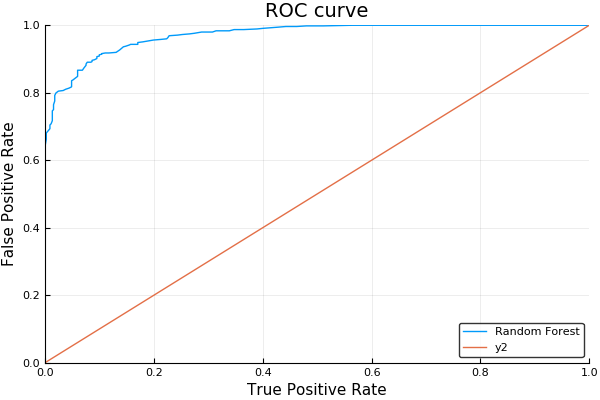

In [19]:
r = roc(test_y,pred)
println("False Positives: ", false_negative(r), "\n")
println("True Negative rate: ", true_negative_rate(r), "\n")
println("F1 score: ", f1score(r), "\n")
r

scores = apply_forest_proba(forest,test_x, [0,1]);
r = roc(test_y, scores[:,1]);

using Plots

x = []
y = []
for roc in r
    push!(x,true_positive_rate(roc))
    push!(y,false_positive_rate(roc))
end

plot(x,y,label="Random Forest")
plot!(x,x)
plot!(title = "ROC curve", xlabel = "True Positive Rate", ylabel = "False Positive Rate")

### Cross Validation

Normal K-fold cross validation and stratified K-fold are supported as well as leave-one-out, random subsampling and
stratified random subsampling.

This can be done on indices

In [40]:
# returns the 10 fold indices with indices 1 to length of X
collect(Kfold(size(X)[1],3))

3-element Array{Any,1}:
 [1, 2, 4, 6, 7, 9, 11, 12, 13, 14  …  987, 988, 991, 993, 994, 995, 997, 998, 999, 1000]
 [1, 3, 4, 5, 7, 8, 10, 11, 12, 14  …  988, 989, 990, 991, 992, 993, 996, 997, 999, 1000]
 [2, 3, 5, 6, 8, 9, 10, 13, 15, 16  …  983, 984, 986, 989, 990, 992, 994, 995, 996, 998] 

Cross validation may be performed using the *cross_validate* function. To do this we must create
predictor and evaluator functions and pass a cross validation scheme as follows

In [48]:
function estfun(id)
    return build_forest(Y[id],X[id,:],5,200)
end

function evalfun(model, id)
    return correctrate(Y[id], 1*apply_forest(model,X[id,:]))
end
# perform 3-fold cross validation for the random forest model 
cross_validate(estfun,evalfun,size(X)[1], Kfold(size(X)[1],3))

3-element Array{Float64,1}:
 0.927928
 0.901198
 0.921922

### Model Hyperparameter Tuning

A grid search *gridtune* is implemented following a similar structure to the *cross_validation* function. 

NB it appears the order of hyperparameters matters otherwise it runs with *forest_size* as the *random_features* parameter!

In [74]:
function estfun(random_features,forest_size)
    return build_forest(Y,X,random_features,forest_size)
end

function evalfun(model)
    return correctrate(test_y, 1*apply_forest(model,test_x))
end

best_model, best_config, best_score = gridtune(estfun, 
                                               evalfun, 
                                               ("random_features",[1,2,3,4,5]),
                                               ("forest_size",[100,500,1000]),
                                               verbose=true
)

println("\nBest model: ", best_model)
println("\nBest Configuration: ", best_config)
println("\nBest score: ", best_score)

[random_features=1, forest_size=100] => 0.922
[random_features=2, forest_size=100] => 0.899
[random_features=3, forest_size=100] => 0.904
[random_features=4, forest_size=100] => 0.896
[random_features=5, forest_size=100] => 0.907
[random_features=1, forest_size=500] => 0.915
[random_features=2, forest_size=500] => 0.906
[random_features=3, forest_size=500] => 0.903
[random_features=4, forest_size=500] => 0.902
[random_features=5, forest_size=500] => 0.902
[random_features=1, forest_size=1000] => 0.908
[random_features=2, forest_size=1000] => 0.906
[random_features=3, forest_size=1000] => 0.905
[random_features=4, forest_size=1000] => 0.905
[random_features=5, forest_size=1000] => 0.904

Best model: Ensemble of Decision Trees
Trees:      100
Avg Leaves: 85.02
Avg Depth:  15.68

Best Configuration: (1, 100)

Best score: 0.922
